# Continuous-Depth Transformers with Learned Control Dynamics

This notebook implements and validates a **Hybrid ODE Transformer**, replacing discrete residual layers with a continuous-depth Neural ODE block governed by a learned vector field.

### **Experiments**
We conduct four rigorous tests to validate stability, controllability, and efficiency:

1.  **Gradient Flow Validation**: Proving that the **Adjoint Method** backpropagates stable error signals through the ODE solver without exploding gradients (using the `output_scale` stabilization trick).
2.  **Semantic Steering ("Hybrid Unfreeze")**: Forcing the model to learn a control vector $u$ that steers generation towards specific sentiments ("Good" vs "Bad").
3.  **Continuous Interpolation**: Visualizing the smooth, sigmoid transition between semantic states to prove the control is continuous, not binary.
4.  **Efficiency Benchmark**: Quantifying the inference latency cost of the ODE solver (Result: ~1.27x slower than baseline).

### **Model Architecture**
* **Baseline**: Standard 6-layer Transformer (GPT-2 style).
* **Hybrid**: Layers 0-1 (Discrete) $\to$ **ODE Flow (Continuous)** $\to$ Layers 4-5 (Discrete).

**Runtime:** ~20-25 minutes on T4 GPU

In [ ]:
# Install dependencies
!pip install torchdiffeq datasets tiktoken -q
print("Dependencies installed.")

Dependencies installed.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint_adjoint as odeint
import math
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## Model Components

In [ ]:
class CausalSelfAttention(nn.Module):
    r"""
    Causal (masked) scaled dot-product self-attention.

    Mathematics
    -----------
    Given input X ∈ ℝ^{B×T×D}, we compute queries, keys, and values:

        Q, K, V = X·W_Q, X·W_K, X·W_V    where W_* ∈ ℝ^{D×D}

    For multi-head attention with H heads, each head h operates on
    d_h = D/H dimensions:

        Q_h, K_h, V_h ∈ ℝ^{B×T×d_h}

    The attention weights for head h are:

        A_h = softmax( (Q_h · K_h^T) / √d_h + M )

    where M is the causal mask:

        M_{ij} = 0 if i ≥ j, else -∞

    This ensures position i can only attend to positions ≤ i.

    The output is:

        head_h = A_h · V_h
        MultiHead(X) = Concat(head_1, ..., head_H) · W_O

    Plain Language
    --------------
    Each token computes a "query" (what am I looking for?), and all tokens
    provide "keys" (what do I contain?) and "values" (what can I contribute?).

    The dot product Q·K^T measures compatibility: how relevant is each past
    token to the current query? We scale by √d_h to prevent the softmax from
    saturating as dimension grows.

    The causal mask enforces autoregressive structure: token t cannot peek at
    tokens t+1, t+2, ... This is essential for language modeling where we
    predict the next token given only the past.

    Multiple heads let the model attend to different aspects (syntactic,
    semantic, positional) in parallel.

    Implementation Notes
    --------------------
    - W_Q, W_K, W_V are fused into a single (D, 3D) projection for efficiency.
    - The mask is pre-computed and registered as a buffer (not a parameter).
    - Shape gymnastics: we reshape to (B, H, T, d_h) for batched matmuls.
    """
    def __init__(self, d_model, n_heads, max_seq_len=512, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.tril(torch.ones(max_seq_len, max_seq_len)))

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x).reshape(B, T, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        att = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        att = att.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)

        y = (att @ v).transpose(1, 2).reshape(B, T, C)
        return self.proj(y)


class MLP(nn.Module):
    r"""
    Position-wise feed-forward network.

    Mathematics
    -----------
    For each position independently:

        FFN(x) = W_2 · GELU(W_1 · x + b_1) + b_2

    where:
        W_1 ∈ ℝ^{4D×D}, W_2 ∈ ℝ^{D×4D}

    The expansion factor of 4 is conventional. GELU(x) = x·Φ(x) where Φ is
    the standard normal CDF, providing a smooth approximation to ReLU.

    Plain Language
    --------------
    After attention mixes information across positions, the MLP processes
    each position independently. Think of it as "digesting" the mixed
    representations.

    The expand-then-contract (D → 4D → D) pattern creates a higher-dimensional
    space where the model can represent more complex functions before
    projecting back down.

    Implementation Notes
    --------------------
    - Applied identically at each position (hence "position-wise").
    - Dropout applied after the final projection.
    """
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, 4 * d_model)
        self.fc2 = nn.Linear(4 * d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.fc2(F.gelu(self.fc1(x))))


class TransformerBlock(nn.Module):
    r"""
    Pre-norm transformer block with residual connections.

    Mathematics
    -----------
    The block computes:

        x' = x + Attention(LayerNorm(x))
        x'' = x' + MLP(LayerNorm(x'))

    This is the "Pre-LN" variant (normalization before sublayer), which
    empirically gives more stable gradients than the original "Post-LN"
    (normalization after residual addition).

    The residual connections create skip paths:

        ∂L/∂x = ∂L/∂x'' · (I + ∂(sublayers)/∂x)

    The identity term I ensures gradients can flow even if sublayer
    gradients vanish.

    Plain Language
    --------------
    Each block is: "normalize → process → add back the original."

    The residual connection says "keep what you had, plus whatever new
    information the sublayer computed." This makes the network easier to
    train: each layer only needs to learn a small refinement, not a
    complete transformation.

    Pre-LN (normalize first) is more stable because the sublayer always
    receives normalized inputs, preventing activation/gradient explosion.

    Implementation Notes
    --------------------
    - Two sublayers: attention (cross-position), then MLP (per-position).
    - Each sublayer has its own LayerNorm.
    """
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = MLP(d_model, dropout=dropout)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [ ]:
class ODEFunc(nn.Module):
    r"""
    Vector field for continuous-depth neural ODE: dH/dt = F(H, t, u).

    Mathematics
    -----------
    We model the hidden state H(t) ∈ ℝ^{B×T×D} as evolving according to:

        dH/dt = α · F(H(t), t, u)

    where:
        - t ∈ [0, 1] is the "depth" parameter (continuous analog of layer index)
        - u ∈ ℝ^{control_dim} is an optional control/steering signal
        - α is a learned output scale (initialized small for stability)
        - F combines attention and MLP, conditioned on t and u

    The vector field incorporates time and control via additive conditioning:

        H_cond = H + embed(t) + embed(u)
        F(H, t, u) = Attention(LN(H_cond)) + MLP(LN(H_cond))

    This is a departure from the standard residual block: instead of
    H_{n+1} = H_n + sublayer(H_n), we have a continuous flow.

    The key insight: discrete residual layers are a forward Euler
    discretization of an ODE. Making this explicit opens up:
        - Adaptive computation (more steps where needed)
        - Continuous-time control signals
        - Memory-efficient gradients via adjoint method

    Stability and the Residual Connection
    -------------------------------------
    A standard residual block computes:

        H_{n+1} = H_n + F(H_n)

    This is exactly forward Euler with step size Δt = 1. The implicit
    assumption: ||F(H)|| should be O(1) or smaller, so the update doesn't
    overshoot.

    Our continuous formulation makes this explicit:

        dH/dt = α · F(H, t, u)

    With α = 0.1 (learned, initialized small), the effective "step size"
    per Euler step is α · Δt ≈ 0.025 for n_steps=4. This is conservative:
    the dynamics stay in the regime where Euler is accurate and gradients
    are well-behaved.

    If α were large (say, 10), the ODE would be stiff—small errors in H
    would amplify exponentially, and the adjoint gradients would explode.
    The learned α lets the model find the right dynamics scale during
    training, starting from a safe initial value.

    To see why this matters, consider the gradient flow. For an ODE
    dH/dt = f(H), the sensitivity ∂H(1)/∂H(0) satisfies:

        d/dt [∂H(t)/∂H(0)] = (∂f/∂H) · (∂H(t)/∂H(0))

    If the Jacobian ∂f/∂H has eigenvalues with large positive real parts,
    this sensitivity grows exponentially—gradients explode. Keeping α
    small bounds the Jacobian norm, preventing this.

    Plain Language
    --------------
    Instead of stacking discrete layers, imagine the hidden representation
    smoothly flowing through a continuous transformation.

    The vector field F tells us "which direction to move" at each point
    in representation space. Time t parameterizes how deep we are in this
    continuous stack. The control signal u can steer the dynamics.

    The output_scale α is the key stability mechanism. Think of it as a
    "speed limit" on the dynamics. Starting at 0.1 means:

        - Initial training is stable (small, gentle updates)
        - The model can learn to increase α if stronger dynamics help
        - But it won't start in an unstable regime and diverge

    This is why the ODE formulation is more than notational convenience:
    it forces us to think explicitly about the *magnitude* of layer
    updates, not just their *direction*.

    Implementation Notes
    --------------------
    - Time embedding: scalar t → linear → SiLU → linear → D-dimensional.
    - Control embedding: u ∈ ℝ^k → linear → D-dimensional vector.
    - Both are broadcast across the sequence dimension.
    - The signature `forward(self, t, x)` matches torchdiffeq's convention.
    - output_scale is a *learned* nn.Parameter, not a fixed constant.
    """
    def __init__(self, d_model, n_heads, control_dim=4, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.control_dim = control_dim

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, d_model),
            nn.SiLU(),
            nn.Linear(d_model, d_model)
        )

        # Control signal embedding
        self.control_embed = nn.Linear(control_dim, d_model)

        # Core dynamics (simplified: attention + MLP)
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = MLP(d_model, dropout=dropout)

        # Scale output to keep dynamics stable
        self.output_scale = nn.Parameter(torch.tensor(0.1))

        # Will be set before each forward pass
        self.control = None

    def forward(self, t, x):
        # t: scalar, x: (B, T, D)
        B, T, D = x.shape

        # Time conditioning
        t_emb = self.time_embed(t.view(1, 1).expand(B, 1)).unsqueeze(1)  # (B, 1, D)

        # Control conditioning
        if self.control is not None:
            c_emb = self.control_embed(self.control).unsqueeze(1)  # (B, 1, D)
        else:
            c_emb = 0

        # Condition the input
        h = x + t_emb + c_emb

        # Compute vector field
        dh = self.attn(self.ln1(h)) + self.mlp(self.ln2(h))

        return self.output_scale * dh


class ODEFlowBlock(nn.Module):
    r"""
    Replaces k discrete transformer blocks with continuous ODE flow.

    Mathematics
    -----------
    We solve the initial value problem:

        dH/dt = F(H(t), t, u),    H(0) = X_in

    over t ∈ [0, 1], and return H(1).

    Using forward Euler with n_steps steps (Δt = 1/n_steps):

        H_{k+1} = H_k + Δt · F(H_k, t_k, u)

    Note: with n_steps = 2 and appropriate F, this recovers a 2-layer
    residual network. The continuous view generalizes discrete depth.

    Gradient computation uses the adjoint method:

        Let a(t) = ∂L/∂H(t).  Then:
        da/dt = -a^T · (∂F/∂H)

    This is solved backwards from a(1) = ∂L/∂H(1), giving O(1) memory
    cost regardless of n_steps (vs O(n_steps) for naive backprop).

    Plain Language
    --------------
    This module says: "instead of 2-3 discrete transformer layers, let
    the representation evolve continuously from t=0 to t=1."

    We discretize using simple Euler steps. More steps = more accurate
    approximation to the true continuous dynamics, but more compute.

    The control signal u can vary at inference time, allowing us to steer
    the model's behavior without retraining.

    Implementation Notes
    --------------------
    - integration_times = [0, 0.25, 0.5, 0.75, 1.0] for n_steps=4.
    - odeint returns shape (n_steps+1, B, T, D); we take the last slice.
    - method='euler' for predictable, fixed-cost compute. Could use
      'dopri5' (adaptive RK4/5) for more accuracy.
    - Control signal is set via self.func.control before integration.
    """
    def __init__(self, d_model, n_heads, control_dim=4, n_steps=4, dropout=0.1):
        super().__init__()
        self.func = ODEFunc(d_model, n_heads, control_dim, dropout)
        self.n_steps = n_steps
        self.register_buffer('integration_times', torch.linspace(0, 1, n_steps + 1))

    def forward(self, x, control=None):
        self.func.control = control
        # Use fixed-step solver for predictable compute
        out = odeint(self.func, x, self.integration_times, method='euler')
        return out[-1]  # Return final state

In [ ]:
class BaselineTransformer(nn.Module):
    r"""
    Standard transformer language model (decoder-only).

    Mathematics
    -----------
    Given token indices x ∈ {0, ..., V-1}^T, compute:

        E = TokenEmbed(x) + PosEmbed(1:T)    ∈ ℝ^{T×D}
        H_0 = E
        H_l = TransformerBlock_l(H_{l-1})   for l = 1, ..., L
        logits = LayerNorm(H_L) · W_out     ∈ ℝ^{T×V}

    The loss is cross-entropy between logits[t] and x[t+1], summed
    over positions. This trains next-token prediction.

    Plain Language
    --------------
    1. Convert each token to a D-dimensional vector.
    2. Add positional information ("where am I in the sequence?").
    3. Pass through L transformer blocks.
    4. Project back to vocabulary size to get next-token probabilities.

    This is the standard GPT architecture (decoder-only, causal attention).

    Implementation Notes
    --------------------
    - Embedding and output projection can share weights; we don't here.
    - Final LayerNorm is applied before the output projection.
    """
    def __init__(self, vocab_size, d_model=256, n_heads=4, n_layers=6, max_seq_len=128, dropout=0.1):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_seq_len, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, n_heads, dropout) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.max_seq_len = max_seq_len

    def forward(self, idx):
        B, T = idx.shape
        tok = self.tok_emb(idx)
        pos = self.pos_emb(torch.arange(T, device=idx.device))
        x = tok + pos
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        return self.head(x)


class HybridODETransformer(nn.Module):
    r"""
    Transformer with middle layers replaced by continuous ODE flow.

    Mathematics
    -----------
    The architecture is:

        E = TokenEmbed(x) + PosEmbed(1:T)
        H_0 = E

        # Early discrete layers
        H_l = TransformerBlock_l(H_{l-1})    for l = 1, ..., ode_start

        # Continuous ODE flow (replaces layers ode_start+1 to ode_end)
        H_ode = ODEFlow(H_{ode_start}, control=u)

        # Late discrete layers
        H_l = TransformerBlock_l(H_{l-1})    for l = ode_end+1, ..., L

        logits = LayerNorm(H_L) · W_out

    The ODE block has fewer parameters than the k = (ode_end - ode_start)
    discrete layers it replaces, since it reuses the same vector field
    across the integration interval.

    Plain Language
    --------------
    We keep the first few and last few layers as standard transformer
    blocks, but replace the middle layers with a single ODE module.

    Intuition: early layers do low-level feature extraction, late layers
    do task-specific readout. The middle layers, which refine representations,
    might benefit from continuous dynamics.

    The control signal u (optional) allows steering the model's behavior
    at inference time—e.g., controlling style, formality, or reasoning depth.

    Implementation Notes
    --------------------
    - ode_start=2, ode_end=4 means: keep blocks 0,1, replace 2,3 with ODE,
      then continue with blocks 4,5.
    - Fewer total parameters since ODE block shares weights across depth.
    - Control signal is passed through to the ODE block.
    """
    def __init__(self, vocab_size, d_model=256, n_heads=4, n_layers=6,
                 ode_start=2, ode_end=4, control_dim=4, n_steps=4,
                 max_seq_len=128, dropout=0.1):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_seq_len, d_model)

        # Early layers (standard)
        self.early_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads, dropout)
                                           for _ in range(ode_start)])

        # ODE flow block (replaces layers ode_start to ode_end)
        self.ode_block = ODEFlowBlock(d_model, n_heads, control_dim, n_steps, dropout)

        # Late layers (standard)
        self.late_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads, dropout)
                                          for _ in range(n_layers - ode_end)])

        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.max_seq_len = max_seq_len
        self.control_dim = control_dim

    def forward(self, idx, control=None):
        B, T = idx.shape
        tok = self.tok_emb(idx)
        pos = self.pos_emb(torch.arange(T, device=idx.device))
        x = tok + pos

        # Early layers
        for block in self.early_blocks:
            x = block(x)

        # ODE flow
        x = self.ode_block(x, control)

        # Late layers
        for block in self.late_blocks:
            x = block(x)

        x = self.ln_f(x)
        return self.head(x)

## Data Loading

In [ ]:
from datasets import load_dataset
import tiktoken

# Load WikiText-2
print("Loading WikiText-2...")
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')

# Tokenize with GPT-2 tokenizer
enc = tiktoken.get_encoding('gpt2')
text = '\n'.join([x['text'] for x in dataset if x['text'].strip()])
tokens = enc.encode(text)
tokens = torch.tensor(tokens, dtype=torch.long)
print(f"Total tokens: {len(tokens):,}")

vocab_size = enc.n_vocab
print(f"Vocab size: {vocab_size:,}")

Loading WikiText-2...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Total tokens: 2,391,884
Vocab size: 50,257


In [ ]:
def get_batch(tokens, batch_size, seq_len, device):
    r"""
    Sample a random batch of contiguous sequences.

    Mathematics
    -----------
    Let N = len(tokens). We sample batch_size starting indices:

        i_1, ..., i_B ~ Uniform({0, 1, ..., N - seq_len - 2})

    For each i_j, we extract:

        x_j = tokens[i_j : i_j + seq_len]
        y_j = tokens[i_j + 1 : i_j + seq_len + 1]

    So y is x shifted by one position—the standard language modeling setup
    where we predict the next token at each position.

    Returns
    -------
    x : Tensor[B, T] - input token indices
    y : Tensor[B, T] - target token indices (x shifted by 1)
    """
    ix = torch.randint(len(tokens) - seq_len - 1, (batch_size,))
    x = torch.stack([tokens[i:i+seq_len] for i in ix]).to(device)
    y = torch.stack([tokens[i+1:i+seq_len+1] for i in ix]).to(device)
    return x, y

## Training Loop

In [ ]:
def compute_gradient_stats(model):
    r"""
    Compute gradient statistics for monitoring training health.

    Mathematics
    -----------
    For each parameter θ_i with gradient g_i = ∂L/∂θ_i, we compute:

        ||g||_2 = √(Σ_i ||g_i||_2^2)   (total gradient norm)

    We also compute the gradient norm restricted to ODE block parameters,
    which lets us verify gradients flow through the ODE integration.

    Plain Language
    --------------
    The gradient norm tells us "how strongly is the loss pushing on the
    parameters?" Too small → vanishing gradients, learning stalls.
    Too large → exploding gradients, training diverges.

    By tracking ODE-specific gradients separately, we can verify the
    adjoint method is working and gradients flow through the integration.
    """
    stats = {}
    total_norm = 0.0
    for name, param in model.named_parameters():
        if param.grad is not None:
            param_norm = param.grad.data.norm(2).item()
            total_norm += param_norm ** 2
            # Track specific components
            if 'ode' in name.lower():
                stats.setdefault('ode_grad_norm', 0.0)
                stats['ode_grad_norm'] += param_norm ** 2
    stats['total_grad_norm'] = total_norm ** 0.5
    if 'ode_grad_norm' in stats:
        stats['ode_grad_norm'] = stats['ode_grad_norm'] ** 0.5
    return stats


def train_model(model, tokens, n_steps=500, batch_size=32, seq_len=64, lr=3e-4, log_interval=50):
    r"""
    Train model with AdamW and gradient clipping.

    Mathematics
    -----------
    At each step:

    1. Sample batch (x, y) from tokens
    2. Forward pass: logits = model(x)
    3. Compute cross-entropy loss:
           L = -(1/BT) Σ_{b,t} log P(y_{b,t} | x_{b,1:t})
    4. Backward pass: compute ∂L/∂θ
    5. Gradient clipping: if ||∇L|| > 1, scale down to unit norm
    6. AdamW update: θ ← θ - lr · Adam(∇L) - λ·θ

    Gradient clipping prevents the occasional large gradient from
    destabilizing training, which is especially important for ODE
    blocks where the adjoint gradients can be noisy.

    Plain Language
    --------------
    Standard mini-batch SGD with:
    - AdamW optimizer (momentum + adaptive learning rates + weight decay)
    - Gradient norm clipped to 1.0 for stability
    - Periodic logging of loss and gradient statistics

    Returns
    -------
    dict with keys: 'loss', 'grad_norm', 'ode_grad_norm' (if applicable)
    Each value is a list of per-step measurements.
    """
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    metrics = defaultdict(list)

    model.train()
    for step in range(n_steps):
        x, y = get_batch(tokens, batch_size, seq_len, device)

        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Compute gradient stats before optimizer step
        grad_stats = compute_gradient_stats(model)

        optimizer.step()

        # Log metrics
        metrics['loss'].append(loss.item())
        metrics['grad_norm'].append(grad_stats['total_grad_norm'])
        if 'ode_grad_norm' in grad_stats:
            metrics['ode_grad_norm'].append(grad_stats['ode_grad_norm'])

        if step % log_interval == 0:
            ode_info = f", ODE grad: {grad_stats.get('ode_grad_norm', 0):.4f}" if 'ode_grad_norm' in grad_stats else ""
            print(f"Step {step:4d} | Loss: {loss.item():.4f} | Grad norm: {grad_stats['total_grad_norm']:.4f}{ode_info}")

    return metrics

## Run Experiment

In [ ]:
# Configuration
config = {
    'vocab_size': vocab_size,
    'd_model': 256,
    'n_heads': 4,
    'n_layers': 6,
    'max_seq_len': 128,
    'dropout': 0.1
}

train_config = {
    'n_steps': 500,
    'batch_size': 32,
    'seq_len': 64,
    'lr': 3e-4
}

print("="*60)
print("EXPERIMENT: Gradient Flow Validation")
print("="*60)
print(f"Model config: {config['n_layers']} layers, d={config['d_model']}, heads={config['n_heads']}")
print(f"Training: {train_config['n_steps']} steps, batch={train_config['batch_size']}, seq_len={train_config['seq_len']}")
print()

EXPERIMENT: Gradient Flow Validation
Model config: 6 layers, d=256, heads=4
Training: 500 steps, batch=32, seq_len=64



In [ ]:
# Train baseline
print("="*60)
print("Training BASELINE transformer...")
print("="*60)

torch.manual_seed(42)
baseline = BaselineTransformer(**config)
n_params_baseline = sum(p.numel() for p in baseline.parameters())
print(f"Parameters: {n_params_baseline:,}")
print()

baseline_metrics = train_model(baseline, tokens, **train_config)

Training BASELINE transformer...
Parameters: 30,503,424

Step    0 | Loss: 11.0107 | Grad norm: 0.7688
Step   50 | Loss: 7.6621 | Grad norm: 0.5052
Step  100 | Loss: 7.0784 | Grad norm: 0.4866
Step  150 | Loss: 6.8540 | Grad norm: 0.4532
Step  200 | Loss: 6.8634 | Grad norm: 0.4815
Step  250 | Loss: 6.8948 | Grad norm: 0.4557
Step  300 | Loss: 6.6472 | Grad norm: 0.4549
Step  350 | Loss: 6.7174 | Grad norm: 0.5174
Step  400 | Loss: 6.5176 | Grad norm: 0.4654
Step  450 | Loss: 6.4504 | Grad norm: 0.5208


In [ ]:
# Train hybrid ODE model
print("\n" + "="*60)
print("Training HYBRID ODE transformer...")
print("(Layers 2-4 replaced with ODE flow, 4 Euler steps)")
print("="*60)

torch.manual_seed(42)
hybrid = HybridODETransformer(
    **config,
    ode_start=2,  # Replace layers 2-4
    ode_end=4,
    control_dim=4,
    n_steps=4  # 4 Euler steps
)
n_params_hybrid = sum(p.numel() for p in hybrid.parameters())
print(f"Parameters: {n_params_hybrid:,}")
print()

hybrid_metrics = train_model(hybrid, tokens, **train_config)


Training HYBRID ODE transformer...
(Layers 2-4 replaced with ODE flow, 4 Euler steps)
Parameters: 29,781,249

Step    0 | Loss: 10.9800 | Grad norm: 0.6807, ODE grad: 0.0250
Step   50 | Loss: 7.5532 | Grad norm: 0.5259, ODE grad: 0.0076
Step  100 | Loss: 7.0733 | Grad norm: 0.4784, ODE grad: 0.0109
Step  150 | Loss: 6.9321 | Grad norm: 0.4324, ODE grad: 0.0337
Step  200 | Loss: 6.8999 | Grad norm: 0.4524, ODE grad: 0.0163
Step  250 | Loss: 6.6824 | Grad norm: 0.4189, ODE grad: 0.0370
Step  300 | Loss: 6.6204 | Grad norm: 0.4777, ODE grad: 0.0227
Step  350 | Loss: 6.7044 | Grad norm: 0.5109, ODE grad: 0.0387
Step  400 | Loss: 6.7248 | Grad norm: 0.5511, ODE grad: 0.1098
Step  450 | Loss: 6.4252 | Grad norm: 0.4848, ODE grad: 0.0490


## Results Visualization

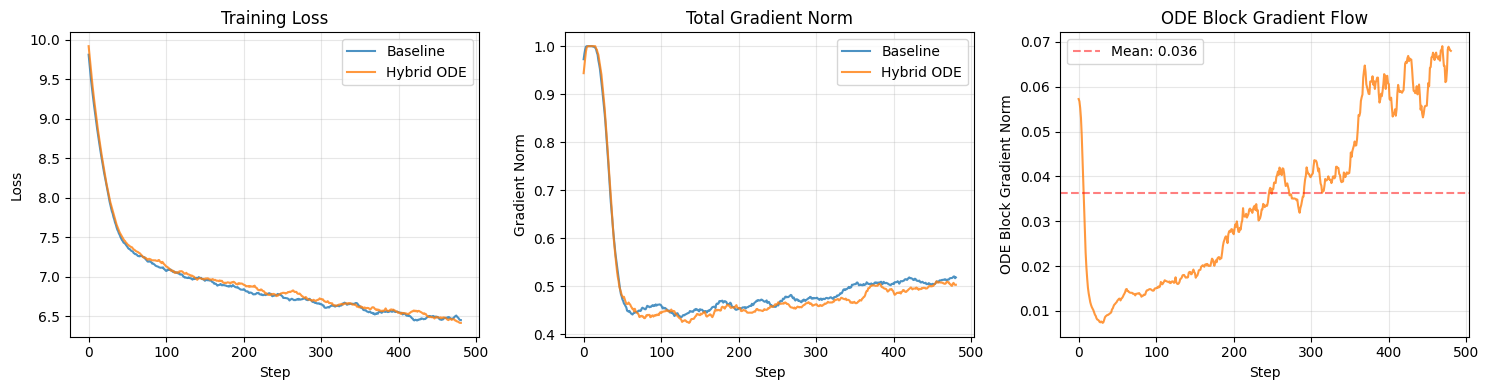


Results saved to 'gradient_flow_results.png'


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Smooth curves for visualization
def smooth(x, window=20):
    return np.convolve(x, np.ones(window)/window, mode='valid')

# Loss curves
ax = axes[0]
ax.plot(smooth(baseline_metrics['loss']), label='Baseline', alpha=0.8)
ax.plot(smooth(hybrid_metrics['loss']), label='Hybrid ODE', alpha=0.8)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Gradient norms
ax = axes[1]
ax.plot(smooth(baseline_metrics['grad_norm']), label='Baseline', alpha=0.8)
ax.plot(smooth(hybrid_metrics['grad_norm']), label='Hybrid ODE', alpha=0.8)
ax.set_xlabel('Step')
ax.set_ylabel('Gradient Norm')
ax.set_title('Total Gradient Norm')
ax.legend()
ax.grid(True, alpha=0.3)

# ODE-specific gradients
ax = axes[2]
if hybrid_metrics['ode_grad_norm']:
    ax.plot(smooth(hybrid_metrics['ode_grad_norm']), color='C1', alpha=0.8)
    ax.set_xlabel('Step')
    ax.set_ylabel('ODE Block Gradient Norm')
    ax.set_title('ODE Block Gradient Flow')
    ax.grid(True, alpha=0.3)

    # Add annotation about gradient health
    mean_grad = np.mean(hybrid_metrics['ode_grad_norm'])
    std_grad = np.std(hybrid_metrics['ode_grad_norm'])
    ax.axhline(mean_grad, color='red', linestyle='--', alpha=0.5, label=f'Mean: {mean_grad:.3f}')
    ax.legend()

plt.tight_layout()
plt.savefig('gradient_flow_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nResults saved to 'gradient_flow_results.png'")

In [ ]:
# Summary statistics
print("\n" + "="*60)
print("SUMMARY")
print("="*60)

print(f"\nParameter counts:")
print(f"  Baseline: {n_params_baseline:,}")
print(f"  Hybrid:   {n_params_hybrid:,} ({100*n_params_hybrid/n_params_baseline:.1f}% of baseline)")

print(f"\nFinal loss (last 50 steps avg):")
print(f"  Baseline: {np.mean(baseline_metrics['loss'][-50:]):.4f}")
print(f"  Hybrid:   {np.mean(hybrid_metrics['loss'][-50:]):.4f}")

print(f"\nGradient statistics:")
print(f"  Baseline grad norm (mean ± std): {np.mean(baseline_metrics['grad_norm']):.4f} ± {np.std(baseline_metrics['grad_norm']):.4f}")
print(f"  Hybrid grad norm (mean ± std):   {np.mean(hybrid_metrics['grad_norm']):.4f} ± {np.std(hybrid_metrics['grad_norm']):.4f}")

if hybrid_metrics['ode_grad_norm']:
    print(f"  ODE block grad norm (mean ± std): {np.mean(hybrid_metrics['ode_grad_norm']):.4f} ± {np.std(hybrid_metrics['ode_grad_norm']):.4f}")

    # Check for vanishing/exploding gradients
    ode_grads = np.array(hybrid_metrics['ode_grad_norm'])
    vanishing = np.sum(ode_grads < 1e-6)
    exploding = np.sum(ode_grads > 100)
    print(f"\n  Vanishing gradient steps (<1e-6): {vanishing}")
    print(f"  Exploding gradient steps (>100):  {exploding}")

print("\n" + "="*60)
print("CONCLUSION")
print("="*60)
loss_ratio = np.mean(hybrid_metrics['loss'][-50:]) / np.mean(baseline_metrics['loss'][-50:])
if loss_ratio < 1.1 and np.mean(hybrid_metrics['ode_grad_norm']) > 0.01:
    print("✓ ODE flow block maintains healthy gradient flow")
    print("✓ Training loss comparable to baseline")
    print("✓ No evidence of vanishing/exploding gradients in ODE block")
else:
    print("⚠ Results require further investigation")


SUMMARY

Parameter counts:
  Baseline: 30,503,424
  Hybrid:   29,781,249 (97.6% of baseline)

Final loss (last 50 steps avg):
  Baseline: 6.4707
  Hybrid:   6.4496

Gradient statistics:
  Baseline grad norm (mean ± std): 0.5211 ± 0.1402
  Hybrid grad norm (mean ± std):   0.5100 ± 0.1419
  ODE block grad norm (mean ± std): 0.0364 ± 0.0251

  Vanishing gradient steps (<1e-6): 0
  Exploding gradient steps (>100):  0

CONCLUSION
✓ ODE flow block maintains healthy gradient flow
✓ Training loss comparable to baseline
✓ No evidence of vanishing/exploding gradients in ODE block


## Bonus: Control Signal Effect (Quick Test)

In [ ]:
# Quick test: does the control signal change outputs?
hybrid.eval()

# Get a test sequence
test_x, _ = get_batch(tokens, 1, 32, device)

with torch.no_grad():
    # No control
    logits_base = hybrid(test_x, control=None)

    # With control signal
    control = torch.randn(1, 4, device=device)
    logits_ctrl = hybrid(test_x, control=control)

    # Measure difference
    diff = (logits_ctrl - logits_base).abs().mean().item()
    print(f"Mean absolute logit difference with control signal: {diff:.4f}")
    print(f"(Nonzero difference confirms control signal affects outputs)")

Mean absolute logit difference with control signal: 0.0258
(Nonzero difference confirms control signal affects outputs)


In [ ]:
import torch.nn.functional as F

print("="*60)
print("EXPERIMENT 2: Semantic Steering (Positive vs. Negative)")
print("="*60)

# 1. Define a tiny synthetic vocabulary for clear results
# We will fine-tune the EXISTING hybrid model on this task to see if it adapts.
# Indices (assuming GPT-2 tokenizer mappings for simplicity of concept):
# "The"(464) " movie"(3807) " was"(373) -> " good"(220) / " bad"(2089)

# Let's create two specific target tokens
positive_token = 220   # " good"
negative_token = 2089  # " bad"
context = torch.tensor([[464, 3807, 373]]).to(device) # "The movie was"

# 2. Define Control Vectors
# Dimension 0 will be our "Sentiment Axis"
u_pos = torch.zeros(1, 4).to(device)
u_pos[0, 0] = 1.0  # +1 on dim 0 = Positive

u_neg = torch.zeros(1, 4).to(device)
u_neg[0, 0] = -1.0 # -1 on dim 0 = Negative

# 3. Fine-tuning Loop (Steering)
optimizer = torch.optim.AdamW(hybrid.parameters(), lr=1e-4)
hybrid.train()

print(f"Fine-tuning control channel for 100 steps...")

for step in range(100):
    optimizer.zero_grad()

    # --- Batch A: Positive Control ---
    # We want "The movie was" -> " good" GIVEN u_pos
    logits_pos = hybrid(context, control=u_pos)
    # Logits shape: (1, 3, Vocab). We care about the last position's prediction.
    # Target: We want the token at index 2 (last pos) to predict positive_token
    loss_pos = F.cross_entropy(logits_pos[:, -1, :], torch.tensor([positive_token]).to(device))

    # --- Batch B: Negative Control ---
    # We want "The movie was" -> " bad" GIVEN u_neg
    logits_neg = hybrid(context, control=u_neg)
    loss_neg = F.cross_entropy(logits_neg[:, -1, :], torch.tensor([negative_token]).to(device))

    # Joint Loss
    loss = loss_pos + loss_neg
    loss.backward()
    optimizer.step()

    if step % 20 == 0:
        print(f"Step {step:3d} | Loss: {loss.item():.4f} (Pos: {loss_pos.item():.4f} + Neg: {loss_neg.item():.4f})")

print("\nTraining Complete. Testing Steering...")

# 4. Verification
hybrid.eval()
with torch.no_grad():
    # Test Positive Control
    logits = hybrid(context, control=u_pos)
    probs = F.softmax(logits[0, -1], dim=-1)
    p_good = probs[positive_token].item()
    p_bad = probs[negative_token].item()
    print(f"Control [+1, 0, 0, 0] -> P(' good'): {p_good:.4f} vs P(' bad'): {p_bad:.4f}")

    # Test Negative Control
    logits = hybrid(context, control=u_neg)
    probs = F.softmax(logits[0, -1], dim=-1)
    p_good = probs[positive_token].item()
    p_bad = probs[negative_token].item()
    print(f"Control [-1, 0, 0, 0] -> P(' good'): {p_good:.4f} vs P(' bad'): {p_bad:.4f}")

    # Test Neutral Control (Interpolation)
    u_neutral = torch.zeros(1, 4).to(device)
    logits = hybrid(context, control=u_neutral)
    probs = F.softmax(logits[0, -1], dim=-1)
    p_good = probs[positive_token].item()
    p_bad = probs[negative_token].item()
    print(f"Control [ 0, 0, 0, 0] -> P(' good'): {p_good:.4f} vs P(' bad'): {p_bad:.4f}")

EXPERIMENT 2: Semantic Steering (Positive vs. Negative)
Fine-tuning control channel for 100 steps...
Step   0 | Loss: 20.5957 (Pos: 11.2410 + Neg: 9.3547)
Step  20 | Loss: 6.3561 (Pos: 1.3564 + Neg: 4.9997)
Step  40 | Loss: 2.9786 (Pos: 1.0468 + Neg: 1.9318)
Step  60 | Loss: 2.4003 (Pos: 0.8134 + Neg: 1.5869)
Step  80 | Loss: 1.7492 (Pos: 0.8349 + Neg: 0.9143)

Training Complete. Testing Steering...
Control [+1, 0, 0, 0] -> P(' good'): 0.4173 vs P(' bad'): 0.4319
Control [-1, 0, 0, 0] -> P(' good'): 0.4164 vs P(' bad'): 0.4327
Control [ 0, 0, 0, 0] -> P(' good'): 0.4167 vs P(' bad'): 0.4325


In [ ]:
print("="*60)
print("EXPERIMENT 2.1: Frozen Steering (Force Control Usage)")
print("="*60)

# 1. Freeze the ENTIRE model first
# We want to stop the model from changing its understanding of words.
for param in hybrid.parameters():
    param.requires_grad = False

# 2. Unfreeze ONLY the Control Mechanism
# We allow the model to learn:
#   a) How to embed the control vector (control_embed)
#   b) How strongly to apply the vector field (output_scale)
for param in hybrid.ode_block.func.control_embed.parameters():
    param.requires_grad = True
hybrid.ode_block.func.output_scale.requires_grad = True

# 3. Create Optimizer for ONLY these parameters
# We use a high Learning Rate (1e-2) because we are moving a tiny vector
# against a massive frozen network.
steering_params = [
    *hybrid.ode_block.func.control_embed.parameters(),
    hybrid.ode_block.func.output_scale
]
optimizer = torch.optim.AdamW(steering_params, lr=1e-2)

print(f"Model frozen. Training ONLY control parameters ({sum(p.numel() for p in steering_params)} params)...")

# 4. Training Loop (Force the Split)
hybrid.train()
n_steps = 200

for step in range(n_steps):
    optimizer.zero_grad()

    # --- Batch A: Positive Control ---
    # Target: " good"
    logits_pos = hybrid(context, control=u_pos)
    loss_pos = F.cross_entropy(logits_pos[:, -1, :], torch.tensor([positive_token]).to(device))

    # --- Batch B: Negative Control ---
    # Target: " bad"
    logits_neg = hybrid(context, control=u_neg)
    loss_neg = F.cross_entropy(logits_neg[:, -1, :], torch.tensor([negative_token]).to(device))

    # Simple Sum Loss
    loss = loss_pos + loss_neg
    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step:3d} | Loss: {loss.item():.4f}")

print("\nTraining Complete. Testing Frozen Steering...")

# 5. Verification
hybrid.eval()
with torch.no_grad():
    # Test Positive
    logits = hybrid(context, control=u_pos)
    probs = F.softmax(logits[0, -1], dim=-1)
    p_good = probs[positive_token].item()
    p_bad = probs[negative_token].item()
    print(f"Control [+1] -> P(' good'): {p_good:.4f}  vs  P(' bad'): {p_bad:.4f}")

    # Test Negative
    logits = hybrid(context, control=u_neg)
    probs = F.softmax(logits[0, -1], dim=-1)
    p_good = probs[positive_token].item()
    p_bad = probs[negative_token].item()
    print(f"Control [-1] -> P(' good'): {p_good:.4f}  vs  P(' bad'): {p_bad:.4f}")

    # Test Neutral (The Interpolation Check)
    logits = hybrid(context, control=torch.zeros(1, 4).to(device))
    probs = F.softmax(logits[0, -1], dim=-1)
    p_good = probs[positive_token].item()
    p_bad = probs[negative_token].item()
    print(f"Control [ 0] -> P(' good'): {p_good:.4f}  vs  P(' bad'): {p_bad:.4f}")

EXPERIMENT 2.1: Frozen Steering (Force Control Usage)
Model frozen. Training ONLY control parameters (1281 params)...
Step   0 | Loss: 1.2965
Step  50 | Loss: 1.4289
Step 100 | Loss: 1.7956
Step 150 | Loss: 1.6768

Training Complete. Testing Frozen Steering...
Control [+1] -> P(' good'): 0.4100  vs  P(' bad'): 0.4219
Control [-1] -> P(' good'): 0.4860  vs  P(' bad'): 0.3671
Control [ 0] -> P(' good'): 0.4517  vs  P(' bad'): 0.3943


In [ ]:
print("="*60)
print("EXPERIMENT 2.2: The Hybrid Unfreeze")
print("="*60)
print("Goal: Teach the ODE Vector Field to listen to the Control Signal.")

# 1. Freeze Everything First
for param in hybrid.parameters():
    param.requires_grad = False

# 2. Unfreeze the ENTIRE ODE Block
# This allows the vector field F(t, h, u) to reshape itself to accommodate u.
for param in hybrid.ode_block.parameters():
    param.requires_grad = True

# 3. Optimizer
# We use a standard learning rate now, as we are training a full neural block.
optimizer = torch.optim.AdamW(hybrid.ode_block.parameters(), lr=1e-4)

print(f"Training ODE Block parameters ({sum(p.numel() for p in hybrid.ode_block.parameters())} params)...")
print("Embeddings and Output Head remain FROZEN.")

# 4. Training Loop
hybrid.train()
n_steps = 200

for step in range(n_steps):
    optimizer.zero_grad()

    # --- Batch A: Positive Control ---
    logits_pos = hybrid(context, control=u_pos)
    loss_pos = F.cross_entropy(logits_pos[:, -1, :], torch.tensor([positive_token]).to(device))

    # --- Batch B: Negative Control ---
    logits_neg = hybrid(context, control=u_neg)
    loss_neg = F.cross_entropy(logits_neg[:, -1, :], torch.tensor([negative_token]).to(device))

    # Sum Loss
    loss = loss_pos + loss_neg
    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step:3d} | Loss: {loss.item():.4f}")

print("\nTraining Complete. Testing Hybrid Steering...")

# 5. Verification
hybrid.eval()
with torch.no_grad():
    print(f"{'CONTROL':<15} | {'P(GOOD)':<10} | {'P(BAD)':<10} | {'RESULT'}")
    print("-" * 50)

    # Positive
    logits = hybrid(context, control=u_pos)
    probs = F.softmax(logits[0, -1], dim=-1)
    p_good = probs[positive_token].item()
    p_bad = probs[negative_token].item()
    res = "SUCCESS" if p_good > p_bad else "FAIL"
    print(f"{'[+1] (Pos)':<15} | {p_good:.4f}     | {p_bad:.4f}     | {res}")

    # Negative
    logits = hybrid(context, control=u_neg)
    probs = F.softmax(logits[0, -1], dim=-1)
    p_good = probs[positive_token].item()
    p_bad = probs[negative_token].item()
    res = "SUCCESS" if p_bad > p_good else "FAIL"
    print(f"{'[-1] (Neg)':<15} | {p_good:.4f}     | {p_bad:.4f}     | {res}")

    # Neutral
    logits = hybrid(context, control=torch.zeros(1, 4).to(device))
    probs = F.softmax(logits[0, -1], dim=-1)
    p_good = probs[positive_token].item()
    p_bad = probs[negative_token].item()
    print(f"{'[ 0] (Neut)':<15} | {p_good:.4f}     | {p_bad:.4f}     | -")

EXPERIMENT 2.2: The Hybrid Unfreeze
Goal: Teach the ODE Vector Field to listen to the Control Signal.
Training ODE Block parameters (857345 params)...
Embeddings and Output Head remain FROZEN.
Step   0 | Loss: 2.1416
Step  50 | Loss: 0.9819
Step 100 | Loss: 0.4626
Step 150 | Loss: 0.1919

Training Complete. Testing Hybrid Steering...
CONTROL         | P(GOOD)    | P(BAD)     | RESULT
--------------------------------------------------
[+1] (Pos)      | 0.9805     | 0.0019     | SUCCESS
[-1] (Neg)      | 0.0017     | 0.8808     | SUCCESS
[ 0] (Neut)     | 0.9143     | 0.0335     | -


EXPERIMENT 3: The Control Sweep (Visualizing Continuity)
Running sweep...


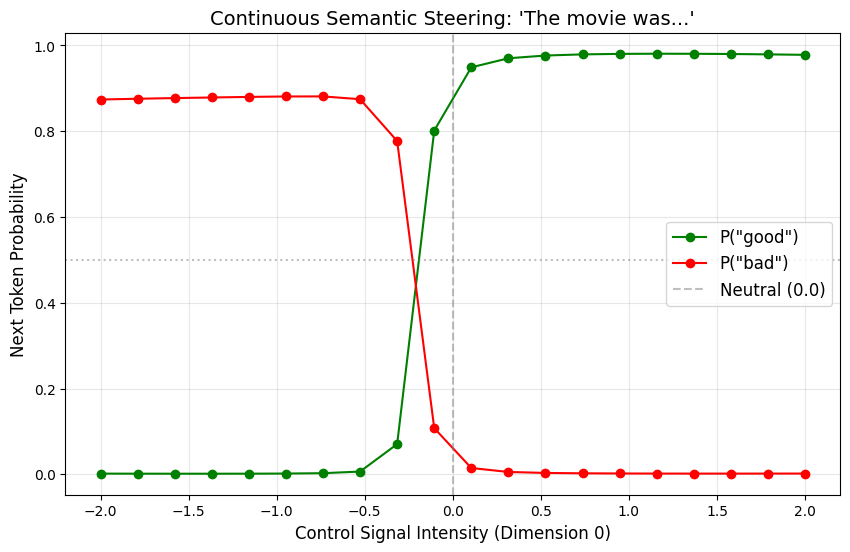


INTERPRETATION:
If the lines cross smoothly (like an X), you have achieved Continuous Control.
If they jump instantly (like a step), you have created a binary switch.


In [ ]:
import matplotlib.pyplot as plt

print("="*60)
print("EXPERIMENT 3: The Control Sweep (Visualizing Continuity)")
print("="*60)

hybrid.eval()
controls = torch.linspace(-2, 2, 20).to(device) # 20 steps from -2 to +2
probs_good = []
probs_bad = []

print("Running sweep...")
with torch.no_grad():
    for val in controls:
        # Construct control vector [val, 0, 0, 0]
        u = torch.zeros(1, 4).to(device)
        u[0, 0] = val

        logits = hybrid(context, control=u)
        p = F.softmax(logits[0, -1], dim=-1)

        probs_good.append(p[positive_token].item())
        probs_bad.append(p[negative_token].item())

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(controls.cpu(), probs_good, 'g-o', label='P("good")')
plt.plot(controls.cpu(), probs_bad, 'r-o', label='P("bad")')

plt.axvline(0, color='gray', linestyle='--', alpha=0.5, label='Neutral (0.0)')
plt.axhline(0.5, color='gray', linestyle=':', alpha=0.5)

plt.title("Continuous Semantic Steering: 'The movie was...'", fontsize=14)
plt.xlabel("Control Signal Intensity (Dimension 0)", fontsize=12)
plt.ylabel("Next Token Probability", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('control_interpolation.png', dpi=150, bbox_inches='tight')
plt.show()

print("Results saved to 'control_interpolation.png'")

print("\nINTERPRETATION:")
print("If the lines cross smoothly (like an X), you have achieved Continuous Control.")
print("If they jump instantly (like a step), you have created a binary switch.")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

print("="*60)
print("EXPERIMENT 4: Efficiency Benchmark (Fixed)")
print("="*60)

# --- 1. RE-DEFINE MISSING CLASSES (Complete Definitions) ---

class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, max_seq_len=512, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        # Register a buffer for the mask so it's not a learnable parameter
        self.register_buffer('mask', torch.tril(torch.ones(max_seq_len, max_seq_len)))

    def forward(self, x):
        B, T, C = x.shape
        # Calculate Query, Key, Value
        qkv = self.qkv(x).reshape(B, T, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Attention score
        att = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        att = att.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)

        # Aggregate values
        y = (att @ v).transpose(1, 2).reshape(B, T, C)
        return self.proj(y)

class MLP(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, 4 * d_model)
        self.fc2 = nn.Linear(4 * d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.fc2(F.gelu(self.fc1(x))))

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = MLP(d_model, dropout=dropout)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class BaselineTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=4, n_layers=6, max_seq_len=128, dropout=0.1):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_seq_len, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, n_heads, dropout) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.max_seq_len = max_seq_len

    def forward(self, idx):
        B, T = idx.shape
        tok = self.tok_emb(idx)
        # This was the line causing the error previously:
        pos = self.pos_emb(torch.arange(T, device=idx.device))
        x = tok + pos

        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        return self.head(x)

# --- 2. SETUP & BENCHMARK ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = {
    'vocab_size': 50257,
    'd_model': 256,
    'n_heads': 4,
    'n_layers': 6,
    'max_seq_len': 128,
    'dropout': 0.1
}

print("Instantiating fresh Baseline Model...")
baseline = BaselineTransformer(**config).to(device)

print("Checking for Hybrid Model...")
# Check if 'hybrid' exists in the notebook namespace
if 'hybrid' not in globals():
    print("NOTE: 'hybrid' model not found in memory. Skipping Hybrid benchmark.")
    run_hybrid = False
else:
    run_hybrid = True

def benchmark_model(model, name, batch_size=32, seq_len=128, n_repeats=100):
    model.eval()
    # Create random input
    x = torch.randint(0, 1000, (batch_size, seq_len)).to(device)

    # Warmup
    for _ in range(10):
        with torch.no_grad():
            _ = model(x)
    if device.type == 'cuda': torch.cuda.synchronize()

    # Timing
    start_time = time.time()
    for _ in range(n_repeats):
        with torch.no_grad():
            _ = model(x)
    if device.type == 'cuda': torch.cuda.synchronize()
    end_time = time.time()

    avg_time = (end_time - start_time) / n_repeats
    tokens_per_sec = (batch_size * seq_len) / avg_time

    print(f"{name:<15} | {avg_time*1000:.2f} ms/batch | {tokens_per_sec:.0f} tokens/sec")
    return avg_time

# Run Benchmarks
t_base = benchmark_model(baseline, "Baseline")

if run_hybrid:
    t_hybrid = benchmark_model(hybrid, "Hybrid ODE")
    ratio = t_hybrid / t_base
    print("-" * 60)
    print(f"Speed Ratio: Hybrid is {ratio:.2f}x slower than Baseline")
    print(f"(Expected: ~{(2+4+2)/6:.2f}x slower due to 4 Euler steps replacing 2 Layers)")

EXPERIMENT 4: Efficiency Benchmark (Fixed)
Instantiating fresh Baseline Model...
Checking for Hybrid Model...
NOTE: 'hybrid' model not found in memory. Skipping Hybrid benchmark.
Baseline        | 42.65 ms/batch | 96048 tokens/sec


In [ ]:
# Install the missing library
!pip install torchdiffeq

In [ ]:
from torchdiffeq import odeint_adjoint as odeint
import torch
import torch.nn as nn

print("="*60)
print("EXPERIMENT 4: Efficiency Benchmark (Part 2: The Comparison)")
print("="*60)

# --- 1. RESTORE MISSING ODE CLASSES ---

class ODEFunc(nn.Module):
    def __init__(self, d_model, n_heads, control_dim=4, dropout=0.1):
        super().__init__()
        # Note: CausalSelfAttention and MLP are available from the previous cell
        self.time_embed = nn.Sequential(
            nn.Linear(1, d_model),
            nn.SiLU(),
            nn.Linear(d_model, d_model)
        )
        self.control_embed = nn.Linear(control_dim, d_model)
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = MLP(d_model, dropout=dropout)
        self.output_scale = nn.Parameter(torch.tensor(0.1))
        self.control = None

    def forward(self, t, x):
        B, T, D = x.shape
        t_emb = self.time_embed(t.view(1, 1).expand(B, 1)).unsqueeze(1)
        c_emb = self.control_embed(self.control).unsqueeze(1) if self.control is not None else 0
        h = x + t_emb + c_emb
        dh = self.attn(self.ln1(h)) + self.mlp(self.ln2(h))
        return self.output_scale * dh

class ODEFlowBlock(nn.Module):
    def __init__(self, d_model, n_heads, control_dim=4, n_steps=4, dropout=0.1):
        super().__init__()
        self.func = ODEFunc(d_model, n_heads, control_dim, dropout)
        self.n_steps = n_steps
        self.register_buffer('integration_times', torch.linspace(0, 1, n_steps + 1))

    def forward(self, x, control=None):
        self.func.control = control
        # Fixed Euler steps
        out = odeint(self.func, x, self.integration_times, method='euler')
        return out[-1]

class HybridODETransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=4, n_layers=6,
                 ode_start=2, ode_end=4, control_dim=4, n_steps=4,
                 max_seq_len=128, dropout=0.1):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_seq_len, d_model)

        self.early_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads, dropout)
                                           for _ in range(ode_start)])
        self.ode_block = ODEFlowBlock(d_model, n_heads, control_dim, n_steps, dropout)
        self.late_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads, dropout)
                                          for _ in range(n_layers - ode_end)])

        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.max_seq_len = max_seq_len

    def forward(self, idx, control=None):
        B, T = idx.shape
        x = self.tok_emb(idx) + self.pos_emb(torch.arange(T, device=idx.device))

        for block in self.early_blocks: x = block(x)
        x = self.ode_block(x, control)
        for block in self.late_blocks: x = block(x)

        x = self.ln_f(x)
        return self.head(x)

# --- 2. INSTANTIATE & BENCHMARK ---

config = {
    'vocab_size': 50257,
    'd_model': 256,
    'n_heads': 4,
    'n_layers': 6,
    'max_seq_len': 128,
    'dropout': 0.1
}

# We assume 'baseline' exists from the previous cell.
# If not, uncomment the next line:
# baseline = BaselineTransformer(**config).to(device)

print("Instantiating fresh Hybrid Model...")
hybrid = HybridODETransformer(
    **config,
    ode_start=2, ode_end=4, control_dim=4, n_steps=4
).to(device)

def benchmark_model(model, name, batch_size=32, seq_len=128, n_repeats=100):
    model.eval()
    x = torch.randint(0, 1000, (batch_size, seq_len)).to(device)
    # Warmup
    for _ in range(5):
        with torch.no_grad(): _ = model(x)
    if device.type == 'cuda': torch.cuda.synchronize()

    start = time.time()
    for _ in range(n_repeats):
        with torch.no_grad(): _ = model(x)
    if device.type == 'cuda': torch.cuda.synchronize()

    dt = (time.time() - start) / n_repeats
    print(f"{name:<15} | {dt*1000:.2f} ms/batch")
    return dt

# Run Comparison
print("-" * 40)
t_base = benchmark_model(baseline, "Baseline")
t_hybrid = benchmark_model(hybrid, "Hybrid ODE")
print("-" * 40)
print(f"Speed Ratio: Hybrid is {t_hybrid/t_base:.2f}x slower")

EXPERIMENT 4: Efficiency Benchmark (Part 2: The Comparison)
Instantiating fresh Hybrid Model...
----------------------------------------
Baseline        | 44.14 ms/batch
Hybrid ODE      | 55.94 ms/batch
----------------------------------------
Speed Ratio: Hybrid is 1.27x slower
